In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [53]:
n_cliques = 13
clique_size = 7

def generate_graph(n_cliques, clique_size):

    g = nx.relaxed_caveman_graph(n_cliques, clique_size, 0.2)
    n_nodes = n_cliques * clique_size
    # g = nx.erdos_renyi_graph(n_nodes, 0.3
    # g = nx.powerlaw_cluster_graph(n_nodes, 2, 0.7)
    initial_health = np.random.rand(n_nodes, 1)
    suceptability = np.random.rand(n_nodes, 1)
    # suceptability = np.ones((n_nodes, 1)) * 0.7
    healh_change_natural = np.random.uniform(0.95, 1.05, (n_nodes, 1))

    adj_mat = nx.adjacency_matrix(g).toarray().astype(int)

    return g, initial_health, suceptability, healh_change_natural, adj_mat

/tmp/ipykernel_35371/708334709.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(g).toarray().astype(int)


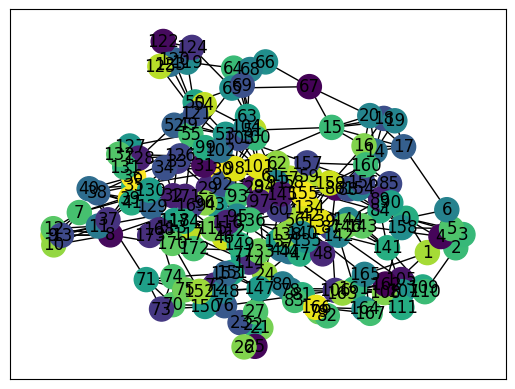

In [55]:
g, initial_health, suceptability, healh_change_natural, adj_mat = generate_graph(25, clique_size)
pos = nx.spring_layout(g)
nx.draw_networkx(g, with_labels=True, node_color=initial_health, pos=pos)

In [6]:
health_hist = []
n_rounds = 10
# fig, ax = plt.subplots(5, 1, figsize=(10, 25))

def simulate(n_rounds, initial_health, suceptability, healh_change_natural, adj_mat):
    health_t = initial_health
    for i in range(n_rounds):
        health_hist.append(health_t)
        health_t = suceptability * (health_t*healh_change_natural) + (1-suceptability)*(adj_mat @ health_t)/adj_mat.sum(axis=1).reshape(-1, 1)
    return health_t



# nx.draw_networkx(g, with_labels=True, node_color=final_health, pos=pos)

In [56]:
n_examples = 10
results = []

for i in range(1):
    g, initial_health, suceptability, healh_change_natural, adj_mat = generate_graph(25, clique_size)

    final_health = simulate(n_rounds, initial_health, suceptability, healh_change_natural, adj_mat)

    res = pd.DataFrame(np.concatenate([initial_health, final_health, suceptability, healh_change_natural], axis=1), 
                    columns=['initial_health', 'final_health', 'suceptability', 'health_change_natural'])

    results.append(res)

    # 

/tmp/ipykernel_35371/708334709.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(g).toarray().astype(int)


In [57]:
res_all = pd.concat(results)

In [58]:
len(res_all)

175

In [59]:
y = res_all['final_health']
X = res_all[['initial_health', 'suceptability']]

In [60]:
res_all.corr()

,initial_health,final_health,suceptability,health_change_natural
initial_health,1.000000,0.359055,0.081172,0.071765
final_health,0.359055,1.000000,0.075367,0.398971
suceptability,0.081172,0.075367,1.000000,-0.024063
health_change_natural,0.071765,0.398971,-0.024063,1.000000


Classical ML Algorithm

In [63]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # model = RandomForestRegressor()
    model = LinearRegression()
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

In [64]:
np.mean(scores)

0.11594960448176925

Graph Neural Networks

In [133]:
import torch_geometric
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [134]:
def r2(y_pred, y_true):
        var_y = torch.var(y_true, unbiased=False)
        mse = ((y_pred.detach()-y_true)**2).mean()
        return 1.0 - mse / var_y

In [135]:
class CustomDS(torch_geometric.data.InMemoryDataset):
    def __init__(
            self, 
            graph, 
            initial_health, 
            suceptability, 
            healh_change_natural,
            health_final,
            transform=None, pre_transform=None):
        super(CustomDS, self).__init__(transform, pre_transform)

        edge_from = [i[0] for i in g.edges]
        edge_to = [i[1] for i in g.edges]

        ei = torch.tensor([
            edge_from,
            edge_to
            ], dtype=torch.long)

        y = torch.tensor(health_final.reshape(-1,1)).float()
        X = torch.tensor(np.concatenate([
            initial_health, 
            suceptability, 
            healh_change_natural], axis=1)).float()

        data = Data(edge_index=ei, y=y, x=X)
        self.data = data

In [136]:
ds = CustomDS(
    g,
    initial_health,
    suceptability,
    healh_change_natural,
    final_health
)

In [140]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(ds.num_node_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = ds[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    # print(loss)
    # loss = F.ll_lo(out, data.y)
    loss.backward()
    optimizer.step()

    print(r2(out, data.y))

    # if epoch % 10 == 0:
        # print((((model(ds[1]) > 0.5 )== ds[1].y).sum())-ds[1].y.sum())